In [1]:
# Importing necessary libraries
import os
from time import time

import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

In [2]:
plt.rcParams['figure.figsize'] = [18, 8]

In [3]:
def extract_zip(zip_path: str, extract_to: str) -> None:
    """Extracts a zip file to a specified directory.

    Args:
        zip_path (str): Path to the zip file.
        extract_to (str): Directory where the zip contents will be extracted.
    """
    import zipfile
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

def load_images_from_folder(folder_path: str, label: int) -> tuple[list[np.ndarray], list[int]]:
    """Loads images and their corresponding labels from a folder.

    Args:
        folder_path (str): Path to the folder containing images.
        label (int): Label assigned to all images in the folder.

    Returns:
        tuple[list[np.ndarray], list[int]]: A list of images and their corresponding labels.
    """
    filenames = os.listdir(folder_path)
    images = [cv2.imread(os.path.join(folder_path, fname), cv2.IMREAD_UNCHANGED) for fname in filenames]
    labels = [label] * len(images)
    return images, labels

def display_sample_images(images: list[np.ndarray], labels: list[int], num_samples: int = 10) -> None:
    """Displays a sample of images with their labels.

    Args:
        images (list[np.ndarray]): List of images.
        labels (list[int]): List of corresponding labels.
        num_samples (int, optional): Number of samples to display. Defaults to 10.
    """
    for cnt, idx in enumerate(np.random.randint(0, len(images), num_samples)):
        plt.subplot(2, 5, cnt + 1)
        plt.imshow(images[idx], cmap='gray', vmin=0, vmax=255)
        plt.title(labels[idx])
        plt.axis('off')
    plt.show()

def preprocess_images(images: list[np.ndarray]) -> np.ndarray:
    """Preprocesses images by flattening and normalizing them.

    Args:
        images (list[np.ndarray]): List of images to preprocess.

    Returns:
        np.ndarray: Preprocessed image data as a flattened and normalized array.
    """
    start = time()
    pixel_data = np.array([image.flatten() for image in images]) / 255.0
    elapsed_time = time() - start
    print(f"Preprocessing completed. Shape: {pixel_data.shape}, Elapsed time: {elapsed_time:.2f} seconds")
    return pixel_data

Loaded 2220 images for class 0.


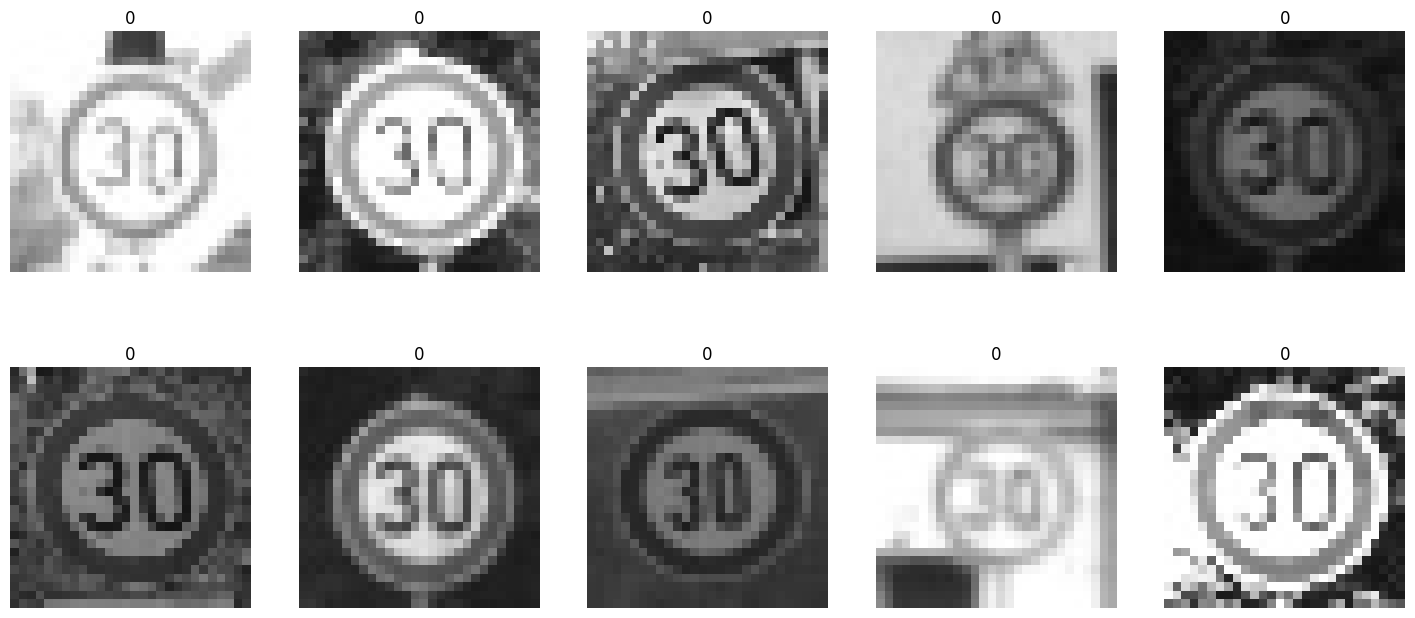

Loaded 2250 images for class 1.


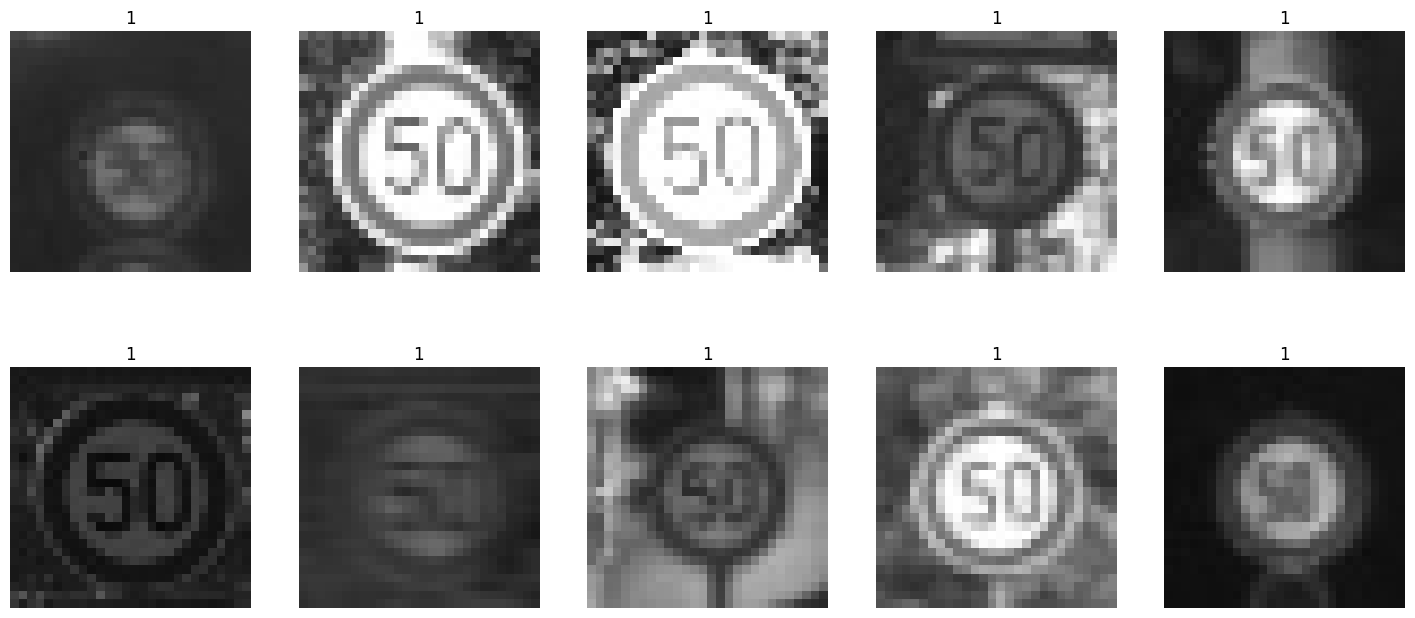

Dataset contains 4470 images and 4470 labels.
Images array shape: (4470, 28, 28)
Labels array shape: (4470,)
Preprocessing completed. Shape: (4470, 784), Elapsed time: 0.02 seconds


In [4]:
# Extract data
#zip_path = '/content/data.zip'
#extract_to = 'data/subset_homework'
#extract_zip(zip_path, extract_to)

# Define dataset folder
dataset_folder = 'data/subset_homework'

# Load and display class 0 images
class_0_folder = os.path.join(dataset_folder, 'class_id_0')
images_class_0, labels_class_0 = load_images_from_folder(class_0_folder, label=0)
print(f"Loaded {len(images_class_0)} images for class 0.")
display_sample_images(images_class_0, labels_class_0)

# Load and display class 1 images
class_1_folder = os.path.join(dataset_folder, 'class_id_1')
images_class_1, labels_class_1 = load_images_from_folder(class_1_folder, label=1)
print(f"Loaded {len(images_class_1)} images for class 1.")
display_sample_images(images_class_1, labels_class_1)

# Combine and shuffle datasets
images = images_class_0 + images_class_1
labels = labels_class_0 + labels_class_1
images, labels = shuffle(images, labels, random_state=42)

print(f"Dataset contains {len(images)} images and {len(labels)} labels.")

# Convert and preprocess images
images_array = np.array(images)
labels_array = np.array(labels)
print(f"Images array shape: {images_array.shape}")
print(f"Labels array shape: {labels_array.shape}")

pixels = preprocess_images(images_array)

In [5]:
def visualize_images(images, labels, predictions=None, num_samples=10):
    """Visualize a set of images with their labels and optional predictions.

    Args:
        images (np.ndarray): Array of images to display.
        labels (np.ndarray): Ground truth labels corresponding to images.
        predictions (np.ndarray, optional): Predicted labels. Defaults to None.
        num_samples (int): Number of images to display. Defaults to 10.
    """
    sample_indices = np.random.randint(0, len(images), num_samples)

    for count, idx in enumerate(sample_indices):
        plt.subplot(2, 5, count + 1)
        plt.imshow(images[idx], cmap="gray", vmin=0, vmax=255)
        title = f"Label: {labels[idx]}"
        if predictions is not None:
            title += f" | Prediction: {predictions[idx]}"
        plt.title(title)
        plt.axis("off")
    plt.show()


def build_linear_model(input_dim):
    """Build a simple linear regression model.

    Args:
        input_dim (int): The number of features for the input.

    Returns:
        tensorflow.keras.Model: Compiled Keras model.
    """
    inputs = Input(shape=(input_dim,))
    outputs = Dense(1, activation="linear")(inputs)
    model = Model(inputs, outputs)
    model.compile(optimizer="adam", loss="mean_squared_error")
    return model


def plot_training_history(history):
    """Plot the loss curve from model training history.

    Args:
        history (tensorflow.keras.callbacks.History): Training history object.
    """
    loss = history.history["loss"]
    epochs = range(len(loss))
    plt.plot(epochs, loss, marker=".", label="Loss")
    plt.grid(True)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training Loss")
    plt.show()


def calculate_accuracy(predictions, labels):
    """Calculate the accuracy of predictions.

    Args:
        predictions (np.ndarray): Predicted binary labels.
        labels (np.ndarray): Ground truth labels.

    Returns:
        float: Accuracy as a fraction.
    """
    return accuracy_score(labels, predictions)

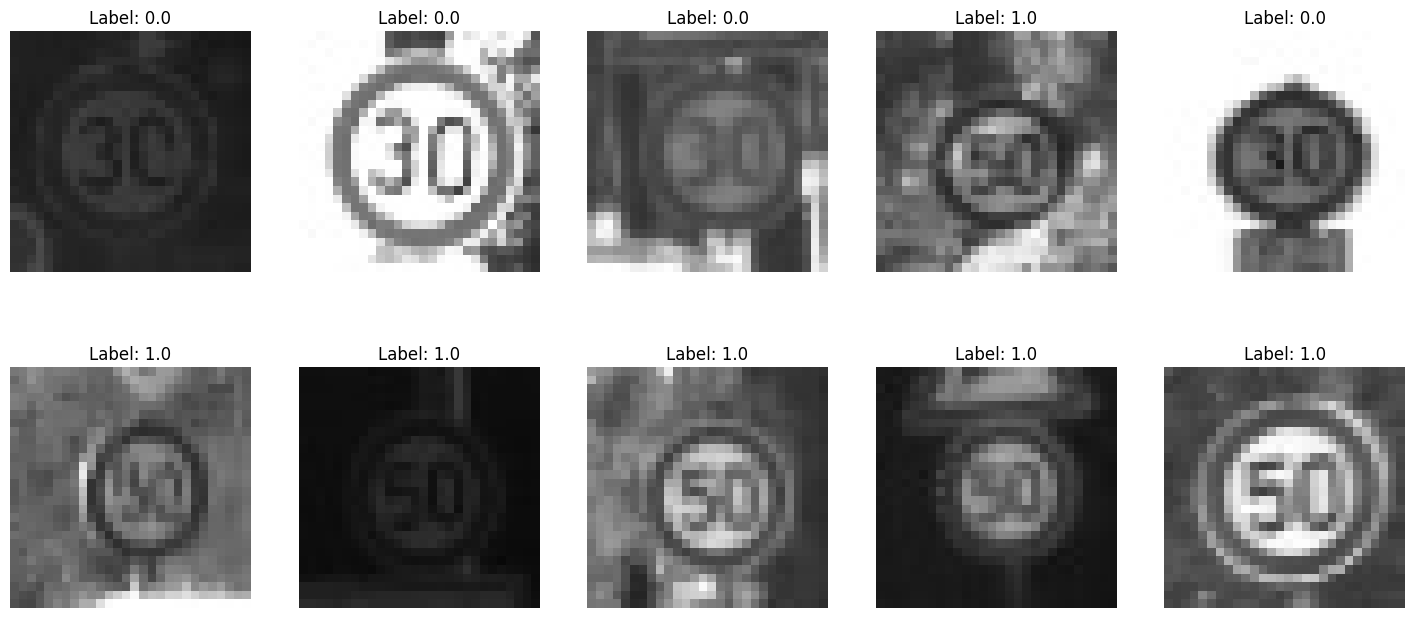

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           785 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 785 (3.07 KB)

 Trainable params: 785 (3.07 KB)

 Non-trainable params: 0 (0.00 B)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.
Epoch 1/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4784
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2582
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2081
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1794
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1616
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1366
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1267
Epoch 8/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1156
Epoch 9/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1107
Epoch 10/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1053


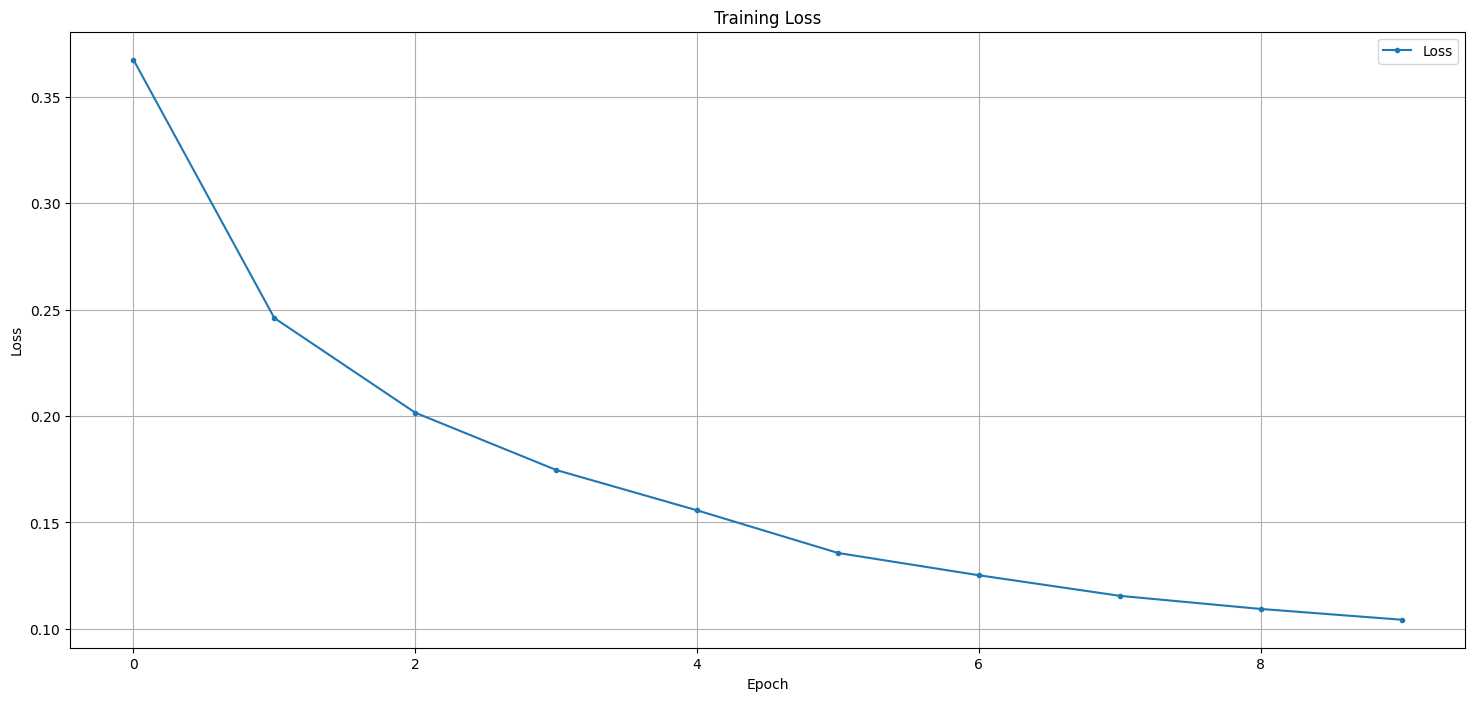

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Sample Prediction: -0.04, True Label: 0.0
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Model Accuracy: 90.47%


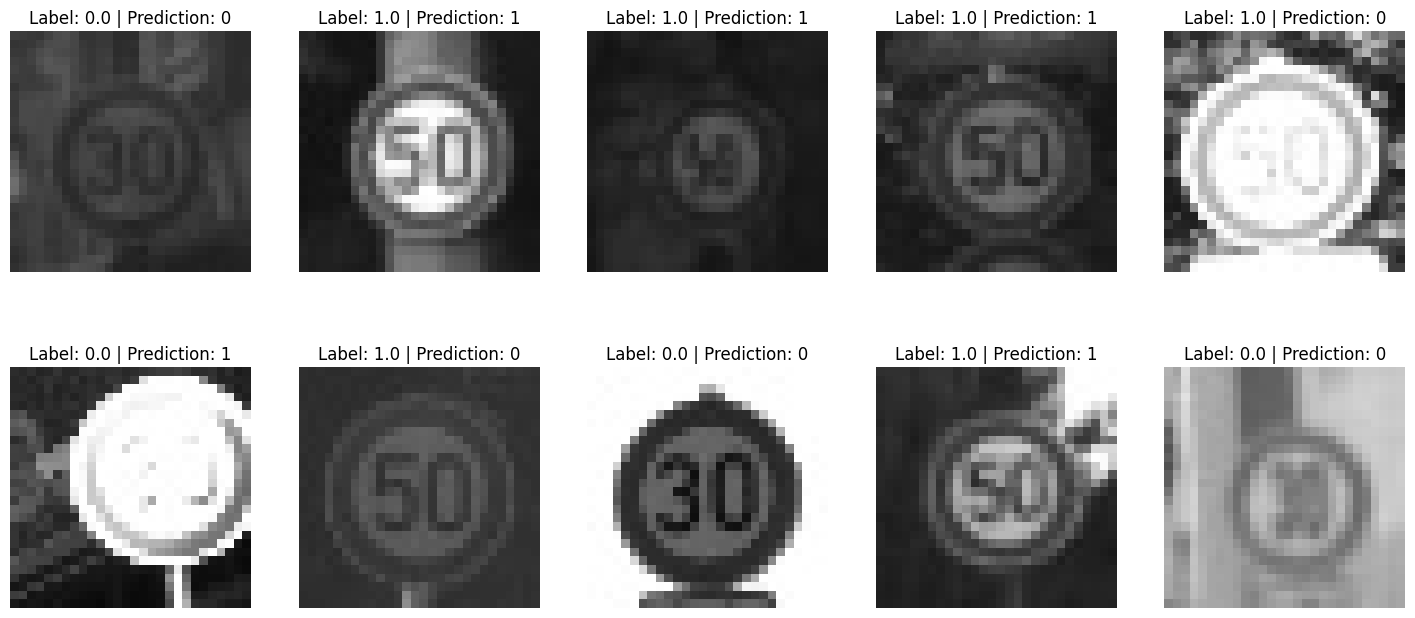

In [6]:
# Constants
BATCH_SIZE = 32
EPOCHS = 10
THRESHOLD = 0.5

pixels = np.array([image.flatten() for image in images], dtype=np.float32) / 255.0
labels = np.array(labels, dtype=np.float32)

# Example dataset preprocessing (assuming pixels and labels are already prepared)
input_dim = pixels.shape[1]

# Visualize random samples of the dataset
visualize_images(images, labels)

# Build and summarize the model
model = build_linear_model(input_dim)
model.summary()

# Plot model architecture
tf.keras.utils.plot_model(model, to_file="model.png", show_shapes=True, show_layer_names=True)

# Train the model
training_history = model.fit(pixels, labels, epochs=EPOCHS, batch_size=BATCH_SIZE)

# Plot the training loss
plot_training_history(training_history)

# Predict on a single sample
sample_idx = 50
sample_prediction = model.predict(pixels[sample_idx:sample_idx + 1, ...])
print(f"Sample Prediction: {sample_prediction[0][0]:.2f}, True Label: {labels[sample_idx]}")

# Predict on the entire dataset
all_predictions = model.predict(pixels).squeeze()
all_predictions_binary = (all_predictions > THRESHOLD).astype(int)

# Calculate accuracy
accuracy = calculate_accuracy(all_predictions_binary, labels)
print(f"Model Accuracy: {accuracy:.2%}")

# Visualize predictions
visualize_images(images, labels, predictions=all_predictions_binary)

In [7]:
def build_model(input_shape: int) -> Model:
    """Builds and compiles a neural network model.
    
    Args:
        input_shape (int): The number of features in the input data.
        
    Returns:
        Model: A compiled TensorFlow Keras model.
    """
    inputs = Input(shape=(input_shape,))
    x = Dense(64, activation="relu")(inputs)
    x = BatchNormalization()(x)  # Normalize after the first dense layer
    x = Dense(32, activation="relu")(x)
    x = BatchNormalization()(x)  # Normalize after the second dense layer
    outputs = Dense(1, activation="sigmoid")(x)  # Sigmoid for binary classification

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
    return model


def plot_training_history(history: dict) -> None:
    """Plots the training loss from the history object.
    
    Args:
        history (dict): A dictionary containing the training loss per epoch.
    """
    epochs = range(len(history["loss"]))
    plt.plot(epochs, history["loss"], ".-", label="Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training History")
    plt.legend()
    plt.grid(True)
    plt.show()


def evaluate_model(predictions: np.ndarray, labels: np.ndarray) -> float:
    """Evaluates the model's accuracy on the dataset.
    
    Args:
        predictions (np.ndarray): Model predictions (binary).
        labels (np.ndarray): True labels.
    
    Returns:
        float: Accuracy of the predictions.
    """
    correct = np.sum(predictions == labels)
    accuracy = correct / len(labels)
    return accuracy

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,737 (206.00 KB)

 Trainable params: 52,545 (205.25 KB)

 Non-trainable params: 192 (768.00 B)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4715 - loss: 0.9107
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7159 - loss: 0.5628 
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8566 - loss: 0.4162
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9516 - loss: 0.3214 
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9722 - loss: 0.2555 
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9866 - loss: 0.1964 
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9885 - loss: 0.1582 
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.1269
Epoch 9/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0925 
Epoch 10/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0763
Epoch 11/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 

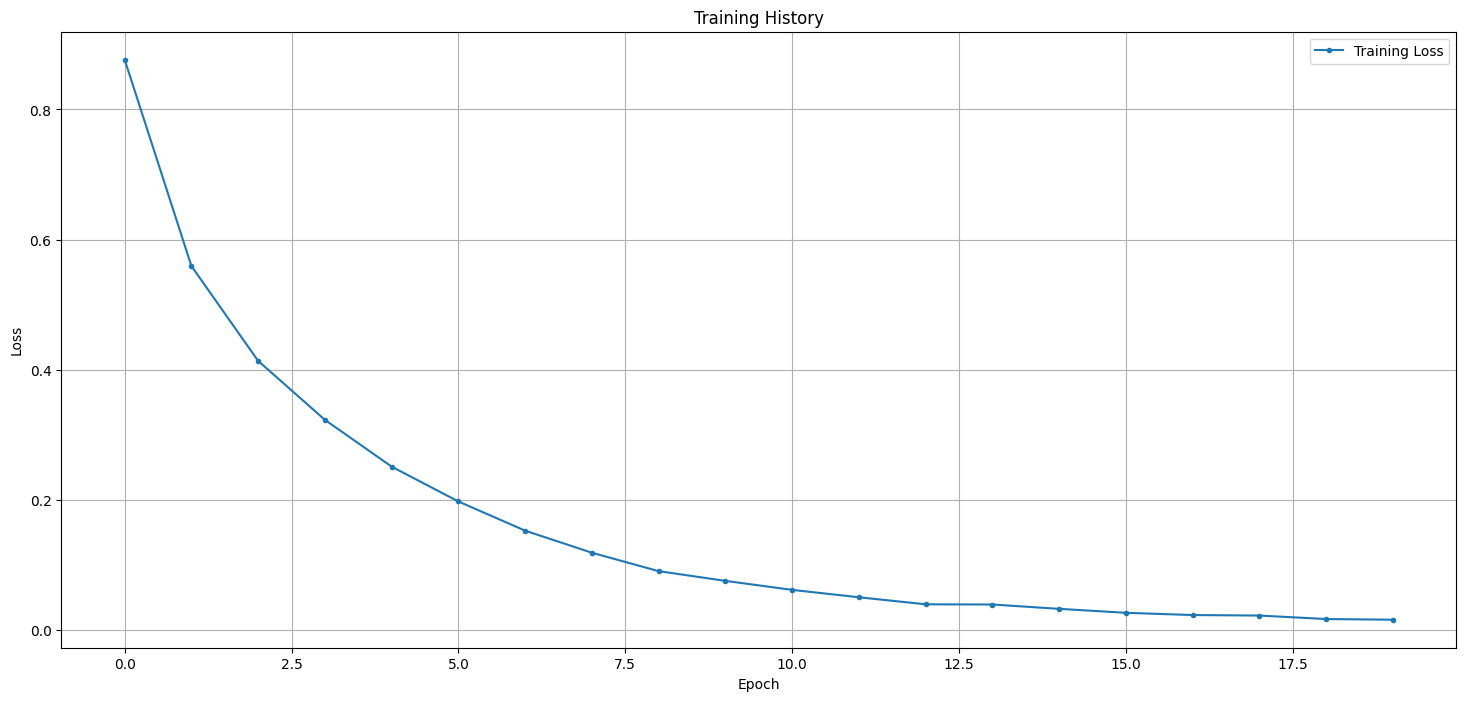

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Model Accuracy: 100.00%
Sample 0: Prediction: False, Label: 0.0
Sample 1: Prediction: False, Label: 0.0
Sample 2: Prediction: False, Label: 0.0
Sample 3: Prediction: False, Label: 0.0
Sample 4: Prediction: True, Label: 1.0
Sample 5: Prediction: True, Label: 1.0
Sample 6: Prediction: False, Label: 0.0
Sample 7: Prediction: False, Label: 0.0
Sample 8: Prediction: True, Label: 1.0
Sample 9: Prediction: True, Label: 1.0


In [8]:
# Assume pixels and labels are preprocessed NumPy arrays
pixels = np.random.rand(1000, 784).astype(np.float32)  # Example data
labels = np.random.randint(0, 2, size=(1000,)).astype(np.float32)  # Binary labels

# Build and summarize the model
model = build_model(pixels.shape[1])
model.summary()
plot_model(model, to_file="model.png", show_shapes=True, show_layer_names=True)

# Train the model
EPOCHS = 20
BATCH_SIZE = 64
history = model.fit(pixels, labels, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

# Plot training history
plot_training_history(history.history)

# Make predictions
raw_predictions = model.predict(pixels).squeeze()
binary_predictions = raw_predictions > 0.5

# Evaluate accuracy
accuracy = evaluate_model(binary_predictions, labels)
print(f"Model Accuracy: {accuracy:.2%}")


for idx in range(10):
    print(f"Sample {idx}: Prediction: {binary_predictions[idx]}, Label: {labels[idx]}")